In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import re

# Load Excel file
data = pd.read_excel(r"C:\Users\Ntsakisib\OneDrive - Customer Loyalty Consultants\Documents - Procurement\Dashboards\Machine Learning For Words\Words.xlsx")

# Extract text data
text_data = data['Words'].astype(str)

# Phrases to exclude
exclude_phrases = [
    "call out",
    "r280 excess",
    "client called",
    "excess fee",
    "exceed r600",
    "costs exceed",
    "hour labour",
    "first hour",
    "covered up",
    "up r2000",
    "client reported",
    "more than",
    "_x000d_ _x000d_",
    "client liable",
    "damage report",
    "exceeds r600",
    "repairs exceed",
    "south africa",
    "than r600",
    "client covered",
    "litre 10",
    "hour labor",
    "will be",
    "broker called",
    "r600 there",
    "report leaking",
    "repairs are",
    "are more",
    "litre 11",
    "r2000 cover",
    "1st hour",
    "cover r2000",
    "amount exceeds"
]

# Additional functional words to exclude
additional_functional_words = [
    "has", "if", "of", "is", "and", "or", "but", "not", "for", "the", "a", "an", "in", "at", "on", "over",
    "under", "above", "below", "between", "among", "through", "into", "upon", "onto", "within", "without",
    "underneath", "behind", "beside", "along", "amongst", "around", "before", "after", "during", "throughout",
    "alongside", "against", "towards", "inside", "outside", "across", "beneath", "amid", "amidst", "per", "via",
    "without", "with", "within", "until", "unless", "upon", "onto", "on", "of", "at", "for", "from", "following",
    "during", "by", "between", "because", "as", "about", "above", "after", "about", "or", "over", "to", "the",
    "that", "these", "those", "this", "those", "those", "that", "it", "him", "her", "them", "they", "he", "she",
    "who", "which", "whose", "whom", "whose", "my", "mine", "your", "yours", "our", "ours", "their", "theirs",
    "its", "his", "hers", "we", "us", "you", "I", "me"
]

# Define common functional words to be excluded
functional_words = set(additional_functional_words + exclude_phrases)

# Function to preprocess text data and exclude specified phrases and functional words
def preprocess_text(text):
    for phrase in exclude_phrases:
        text = text.replace(phrase, "")
    for word in functional_words:
        text = re.sub(r'\b{}\b'.format(word), "", text)  # Using regex to match whole words only
    return text

# Apply preprocessing
text_data = text_data.apply(preprocess_text)

# Initialize CountVectorizer with unigram configuration
vectorizer = CountVectorizer(ngram_range=(1, 1), token_pattern=r'\b\w+\b')

# Tokenize and build vocabulary
X = vectorizer.fit_transform(text_data)

# Get the feature names
feature_names = vectorizer.get_feature_names_out()

# Initialize Naive Bayes classifier
classifier = MultinomialNB()

# Train the classifier
classifier.fit(X, data['Words'])

# Get the vocabulary and word counts
vocab = vectorizer.vocabulary_
word_counts = X.sum(axis=0).A1

# Zip feature names and counts
word_freq = [(feature_names[i], word_counts[i]) for i in range(len(feature_names))]

# Sort by frequency
word_freq.sort(key=lambda x: x[1], reverse=True)

# Create DataFrame for the word frequency
df = pd.DataFrame(word_freq, columns=['Word', 'Frequency'])

# Save to CSV
df.to_csv(r"C:\Users\Ntsakisib\OneDrive - Customer Loyalty Consultants\Documents - Procurement\Dashboards\Machine Learning For Words\common_words.csv", index=False)


In [66]:
WITH Search AS (
    SELECT
        dw.call_date_opened, 
        dw.call_reference_number,
        dw.sub_product_name,
        dw.sub_sub_product_name,
        dw.[PROBLEM DESCRIPTION]
    FROM
        DW_CALL_PAYMENT_REPORT_FROM_2018 dw
    WHERE
        dw.call_date_opened > DATEADD(year, -1, GETDATE())
        AND dw.status_desc <> 'Cancelled'
        AND dw.sub_product_name IN ('Advanced Household/Office', 'Household/Office Assist')
        AND dw.sub_sub_product_name IN (
            'Advanced Geyser Inspection',
            'Advanced Geyser Repair',
            'Advanced Geyser Replacement',
            'Advanced Geyser Warranty Replacement',
            'Geyser Claim',
            'Geyser Replacement',
            'Plumbing',
            'Warranty'   -- corrected spelling from 'Waranty' to 'Warranty'
        )
),

All_geyser AS (
    SELECT * FROM Search 
    WHERE sub_sub_product_name <> 'Plumbing'
    UNION
    SELECT * FROM Search
    WHERE sub_sub_product_name = 'Plumbing' AND [PROBLEM DESCRIPTION] LIKE '%geyser%'
),

Warranty_Geyser AS (
    SELECT DISTINCT
        dw.call_reference_number,
        dw.sub_product_name,
        dw.sub_sub_product_name,
        dw.[PROBLEM DESCRIPTION],
        (
            SELECT TOP 1 nc.call_note
            FROM notes_call nc
            WHERE nc.call_note LIKE '%Warranty%'
            AND nc.call_id = dw.call_id
        ) AS Note
    FROM
        DW_CALL_PAYMENT_REPORT_FROM_2018 dw
    WHERE
        dw.call_reference_number IN (
            SELECT AG.call_reference_number FROM All_geyser AG
        )
        AND dw.call_reference_number IS NOT NULL
        AND dw.sub_product_name IS NOT NULL
        AND dw.sub_sub_product_name IS NOT NULL
        AND dw.[PROBLEM DESCRIPTION] IS NOT NULL
),

All_Warranty_Geysers_Not_Null AS (
    SELECT * FROM Warranty_Geyser
    WHERE Note IS NOT NULL -- Added condition to filter out null values in 'Note' column 
),

Final_Result AS (
    SELECT 
        AG.*, 
        CASE 
            WHEN AG.call_reference_number IN (SELECT AWG.call_reference_number FROM All_Warranty_Geysers_Not_Null AWG) THEN 'Warranty' 
            ELSE 'Repair/Replacement' 
        END AS Type
    FROM 
        All_geyser AG
),

Doc_search AS (
    SELECT DISTINCT
        cm.call_reference_number AS 'Call Ref',
        cm.call_id,
        cm.call_date_opened,
        ISNULL(c.countg, 0) + ISNULL(c2.countn, 0) AS Document_Counter_Invoice,
        CASE WHEN ISNULL(c.doc_type, 0) IN (81, 8, 80) THEN 'Authorization/Damage Report' ELSE 'None' END AS Doc_Name_C1,
        CASE WHEN ISNULL(c2.doc_type, 0) IN (81, 8, 80) THEN 'Authorization/Damage Report/Geyser Replacement Quote' ELSE 'None' END AS Doc_Name_C2
    FROM 
        callmaster cm
    INNER JOIN  DW_CALL_PAYMENT_REPORT_FROM_2018 dw ON dw.call_id = cm.call_id
    LEFT JOIN (
        SELECT SUM(county) AS countg, q1.query_call_id, dd2.doc_type
        FROM (
            SELECT 
                d1.doc_name, d1.doc_type, d1.doc_link_type, d1.doc_valid, 
                d1.doc_description, d1.doc_linkid, COUNT(d1.doc_id) AS county  
            FROM 
                doc_warehouse d1
            GROUP BY 
                d1.doc_name, d1.doc_link_type, d1.doc_type, d1.doc_valid, 
                d1.doc_description, d1.doc_linkid, d1.doc_id, d1.doc_description, d1.doc_date
        ) dd2
        JOIN 
            query q1 ON dd2.doc_linkid = q1.query_id
        WHERE 
            dd2.doc_type IN (81, 8, 80) AND
            dd2.doc_link_type = 3 AND dd2.doc_valid = 1
        GROUP BY 
            q1.query_call_id, dd2.doc_type
    ) c ON cm.call_id = c.query_call_id
    LEFT JOIN (
        SELECT SUM(dddd.countf) AS countn, dddd.doc_linkid, dddd.doc_type
        FROM (
            SELECT 
                dw1.doc_name, dw1.doc_type, dw1.doc_link_type, dw1.doc_valid, 
                dw1.doc_linkid, COUNT(dw1.doc_id) AS countf  
            FROM 
                doc_warehouse dw1  
            WHERE 
                (dw1.doc_type IN (81, 8, 80)) AND
                dw1.doc_link_type = 1 AND
                dw1.doc_valid = 1 
            GROUP BY 
                dw1.doc_name, dw1.doc_link_type, dw1.doc_type, dw1.doc_valid, 
                dw1.doc_linkid, dw1.doc_id
        ) dddd
        GROUP BY 
            dddd.doc_linkid, dddd.doc_type
    ) c2 ON c2.doc_linkid = cm.call_id 
    WHERE
        dw.call_date_opened > DATEADD(year, -1, GETDATE())
        AND dw.status_desc <> 'Cancelled'
        AND dw.sub_product_name IN ('Advanced Household/Office', 'Household/Office Assist')
        AND dw.sub_sub_product_name IN (
            'Advanced Geyser Inspection',
            'Advanced Geyser Repair',
            'Advanced Geyser Replacement',
            'Advanced Geyser Warranty Replacement',
            'Geyser Claim',
            'Geyser Replacement',
            'Plumbing',
            'Warranty'   -- corrected spelling from 'Waranty' to 'Warranty'
        )
    GROUP BY 
        cm.call_reference_number, cm.call_id, cm.call_date_opened, c.countg, c2.countn, c.doc_type, c2.doc_type
    HAVING 
        (ISNULL(c.countg, 0) + ISNULL(c2.countn, 0)) >= 1
)

SELECT FR.*
,


CASE WHEN FR.call_reference_number IN (SELECT ds.[Call Ref] FROM Doc_search ds) THEN 'Replacement' ELSE FR.Type END AS 'Repair/Replacement/Warranty'
FROM Final_Result FR;


Warning: Null value is eliminated by an aggregate or other SET operation.

(8401 rows affected)

Displaying Top 5000 rows.

Total execution time: 00:00:06.007

call_date_opened call_reference_number sub_product_name sub_sub_product_name PROBLEM DESCRIPTION Type Repair/Replacement/Warranty 2023-04-26 09:43:38 677582 Household/Office Assist Geyser Replacement Possible burst geyser. Cover for call out and first hour labor. Damage report needed if burst. Repair/Replacement Repair/Replacement 2023-04-26 12:45:02 677641 Advanced Household/Office Plumbing the clients geyser is not heating up, The client is covered for R2000, if repairs exceed R600, there is a R280 excess that the client has to pay
 Repair/Replacement Repair/Replacement 2023-04-26 13:39:38 677664 Household/Office Assist Plumbing Client Mrs Lauren advised faulty geyser at 20 Polaris StCape Farms, Cape Town SP to compile a damage report and quote 
 Repair/Replacement Repair/Replacement 2023-04-26 16:12:40 677714 Household/Office Assist Geyser Replacement Elle from 27120010900 kingprice called in to report that client has a burst geyser. client covered for call out fee and 1st houe labour. If the geyser is burst please proceed with the replacement using the kingprice geyser limits(a. R8250 excluding vat for 100L and 150L geyser replacements

b. R10120 excluding vat for 200L geyser replacements)

 Warranty Replacement 2023-04-27 09:40:33 677810 Household/Office Assist Plumbing CLIENT CALLED TO REPORT A BURST GEYSER*CALL OUT AND 1ST HOUR LABOR IF ANY PARTS ARE NEEDED WILL EB FOR YOUR OWN ACCOUNT-IF BURST SP TO REPLACE EXCESS IS R1500 Repair/Replacement Repair/Replacement 2023-04-27 12:02:50 677834 Advanced Household/Office Geyser Replacement The broker Liezel 0827712150 called in to authorize the geyser replacement from electrical to gas and here are the limits 150 ltrs R9200 / 200 ltrs R114500 / 250 ltrs R17000. The broker advised that the client will have to intial have to pay for any over the cover amount for the geyser replacement and the issue of the excess will be sorted tomorrow Repair/Replacement Repair/Replacement 2023-04-28 15:25:23 678069 Household/Office Assist Plumbing Burst geyser.- - 50 litre R 11 261.95
- 100 litre R 10 640.95
- 150 litre R 10 774.45
- 200 litre R 13 193.95
- 250 litre R 20 714.95
Repairs R 1750.00
Geyser Component Cover
The Santam Specialist Real Estate Policy Wording Water Heating System is extended to include cover
for repairs to geyser components subject to a maximum of R1 750 (one thousand seven hundred and
fifty rand) per unit per period of insurance.
Period of insurance in terms of this extension of cover is defined as:
Monthly paid policies: 12 calendar months commencing with the inception or review date
Non-monthly paid policies: annual period of insurance commencing with the inception or review date
Claims lodged against this cover will not be subject to a First Amount Payable unless otherwise stated
on the schedule.
Excesses
Geyser Replacement R 1500
Geyser Repair R 250 Repair/Replacement Repair/Replacement 2023-04-28 22:14:37 678111 Advanced Household/Office Plumbing 0662426627 / 0662415412 - John Alger - Unit 51 - LEAKING GEYSER - leaking - lorrainealger@gmail.com - sp can come tomorrow - CLAIM NO IS: WO-0085334 Repair/Replacement Repair/Replacement 2023-04-29 10:44:52 678178 Advanced Household/Office Plumbing Client called in and said that his geyser might be burst. Explained cover- Client is covered up R2000 with an excess fee of R280 if costs exceed. Repair/Replacement Repair/Replacement 2023-04-30 18:46:18 678391 Household/Office Assist Plumbing Client called in and said that the geyser is not getting called at all. Client covered for callout and first hour of labour. Warranty Warranty 2023-05-02 05:37:24 678610 Advanced Household/Office Plumbing The client was contacted 0835151424 who is advised that there is a fauty geyser and needs urgent assitance. The client is covered for R2000 for repairs and if the bill of repairs exceeds R600 there will be R280 excess payable by the client to the service provider. Damage Report and Quotation may be required Repair/R

In [49]:
select distinct
    cm.call_reference_number AS 'Call Ref',
    cm.call_id,
    cm.call_date_opened,
    isnull(c.countg, 0) + isnull(c2.countn, 0) as Document_Counter_Invoice,
   case when   isnull(c.doc_type, 0) in (81,8,80) then 'Authorization/Damage Report' else  'None' end  as Doc_Name_C1,
   case when     isnull(c2.doc_type, 0)    in (81,8,80) then 'Authorization/Damage Report' else  'None' end as Doc_Name_C2
from 
    callmaster cm


    
inner join  DW_CALL_PAYMENT_REPORT_FROM_2018 dw  on dw.call_id =cm.call_id
left join (
    select sum(county) as countg, q1.query_call_id, dd2.doc_type
    from (
        select 
            d1.doc_name, d1.doc_type, d1.doc_link_type, d1.doc_valid, 
            d1.doc_description, d1.doc_linkid, count(d1.doc_id) as county  
        from 
            doc_warehouse d1
       
        group by 
            d1.doc_name, d1.doc_link_type, d1.doc_type, d1.doc_valid, 
            d1.doc_description, d1.doc_linkid, d1.doc_id, d1.doc_description, d1.doc_date
    ) dd2
    join 
        query q1 on dd2.doc_linkid = q1.query_id
    where 
        dd2.doc_type in   (81, 8,80)  and
        dd2.doc_link_type = 3 and dd2.doc_valid = 1
    group by 
        q1.query_call_id, dd2.doc_type
) c ON cm.call_id = c.query_call_id
left join (
    select sum(dddd.countf) as countn, dddd.doc_linkid, dddd.doc_type
    from (
        select 
            dw1.doc_name, dw1.doc_type, dw1.doc_link_type, dw1.doc_valid, 
            dw1.doc_linkid, count(dw1.doc_id) as countf  
        from 
            doc_warehouse dw1  
        where 
            (dw1.doc_type in  (81,8,80) ) and
            dw1.doc_link_type = 1 and
            dw1.doc_valid = 1 
        group by 
            dw1.doc_name, dw1.doc_link_type, dw1.doc_type, dw1.doc_valid, 
            dw1.doc_linkid, dw1.doc_id
    ) dddd
    group by 
        dddd.doc_linkid, dddd.doc_type
) c2 ON c2.doc_linkid = cm.call_id 

where

        dw.call_date_opened > DATEADD(year, -1, GETDATE())
        AND dw.status_desc <> 'Cancelled'
        AND dw.sub_product_name IN ('Advanced Household/Office', 'Household/Office Assist')
        AND dw.sub_sub_product_name IN (
            'Advanced Geyser Inspection',
            'Advanced Geyser Repair',
            'Advanced Geyser Replacement',
            'Advanced Geyser Warranty Replacement',
            'Geyser Claim',
            'Geyser Replacement',
            'Plumbing',
            'Warranty'   -- corrected spelling from 'Waranty' to 'Warranty'
        )
--s.sch_masterid = 86
group by 
    cm.call_reference_number, cm.call_id, cm.call_date_opened, c.countg, c2.countn, c.doc_type, c2.doc_type
having 
    (isnull(c.countg, 0) + isnull(c2.countn, 0)) > 1
order by 
    cm.call_id desc




    ----81	Damage Report

   -- 8	Authorization received

  -- 80	Quotation (Geyser Replacement)


Warning: Null value is eliminated by an aggregate or other SET operation.

(2542 rows affected)

Total execution time: 00:03:07.936

Call Ref call_id call_date_opened Document_Counter_Invoice Doc_Name_C1 Doc_Name_C2 755162 760426 2024-04-24 18:09:22 1 Authorization/Damage Report None 755099 760363 2024-04-24 13:36:43 1 Authorization/Damage Report None 754985 760249 2024-04-24 08:14:46 1 Authorization/Damage Report None 754985 760249 2024-04-24 08:14:46 2 Authorization/Damage Report None 754913 760177 2024-04-23 16:08:15 1 None Authorization/Damage Report/Geyser Replacement Quote 754863 760127 2024-04-23 13:49:37 1 Authorization/Damage Report None 754837 760101 2024-04-23 12:40:25 1 Authorization/Damage Report None 754731 759995 2024-04-23 09:04:51 1 Authorization/Damage Report None 754727 759991 2024-04-23 09:00:43 1 None Authorization/Damage Report/Geyser Replacement Quote 754721 759985 2024-04-23 08:47:06 1 None Authorization/Damage Report/Geyser Replacement Quote 754719 759983 2024-04-23 08:46:10 2 Authorization/Damage Report Authorization/Damage Report/Geyser Replacement Quote 754623 759887 2024-04-22 16:29:56 1 Authorization/Damage Report None 754603 759867 2024-04-22 15:47:21 1 Authorization/Damage Report None 754523 759787 2024-04-22 12:56:33 1 Authorization/Damage Report None 754504 759768 2024-04-22 12:02:54 1 Authorization/Damage Report None 754486 759750 2024-04-22 11:31:14 1 Authorization/Damage Report None 754462 759727 2024-04-22 10:55:43 1 Authorization/Damage Report None 754456 759723 2024-04-22 10:46:10 1 Authorization/Damage Report None 754440 759707 2024-04-22 10:26:10 1 Authorization/Damage Report None 754360 759628 2024-04-22 08:54:13 1 Authorization/Damage Report None 754354 759622 2024-04-22 08:37:44 1 Authorization/Damage Report None 754264 759532 2024-04-21 16:32:28 1 Authorization/Damage Report None 754255 759523 2024-04-21 14:57:09 1 Authorization/Damage Report None 754222 759490 2024-04-21 11:11:54 1 Authorization/Damage Report None 754195 759463 2024-04-21 08:00:01 1 Authorization/Damage Report None 754170 759438 2024-04-20 17:44:47 1 Authorization/Damage Report None 754044 759312 2024-04-20 08:27:48 1 Authorization/Damage Report None 754028 759296 2024-04-20 07:22:45 1 Authorization/Damage Report None 753994 759262 2024-04-19 19:03:03 1 Authorization/Damage Report None 753959 759227 2024-04-19 16:15:28 1 Authorization/Damage Report None 753958 759226 2024-04-19 16:09:44 1 Authorization/Damage Report None 753894 759162 2024-04-19 14:07:38 1 Authorization/Damage Report None 753839 759107 2024-04-19 11:24:53 1 Authorization/Damage Report None 753814 759083 2024-04-19 10:37:47 1 Authorization/Damage Report None 753749 759018 2024-04-19 08:13:51 1 None Authorization/Damage Report/Geyser Replacement Quote 753689 758958 2024-04-18 18:42:09 1 Authorization/Damage Report None 753606 758875 2024-04-18 14:08:39 1 Authorization/Damage Report None 753572 758841 2024-04-18 12:22:24 1 Authorization/Damage Report None 753556 758825 2024-04-18 11:33:49 1 Authorization/Damage Report None 753538 758807 2024-04-18 10:57:25 1 Authorization/Damage Report None 753515 758784 2024-04-18 10:01:27 1 Authorization/Damage Report None 753510 758779 2024-04-18 09:52:04 2 None Authorization/Damage Report/Geyser Replacement Quote 753491 758760 2024-04-18 09:04:04 1 None Authorization/Damage Report/Geyser Replacement Quote 753460 758729 2024-04-18 08:11:39 1 None Authorization/Damage Report/Geyser Replacement Quote 753393 758662 2024-04-17 17:06:33 1 Authorization/Damage Report None 753388 758657 2024-04-17 16:44:10 1 Authorization/Damage Report None 753344 758637 2024-04-17 15:54:32 1 Authorization/Damage Report None 753321 758614 2024-04-17 14:57:04 2 None Authorization/Damage Report/Geyser Replacement Quote 753267 758560 2024-04-17 11:49:51 1 Authorization/Damage Report None 753221 758514 2024-04-17 10:04:25 1 Authorization/Damage Report None 753208 758501 2024-04-17 09:33:06 1 Authorization/Damage Report None 753189 758482 2024-04-17 09:02:31 1 Authorization/Damage Report None 753178 758471 2024-04-17 08:48:36 1 Authorization/Damage Report None 753169 75846

In [71]:
select 
sp.service_provider_name ,sp.service_provider_email_address, sp.sp_finance_email_address

from service_providers  sp  

where sp.service_provider_name ='MSNH Maintenance CC'







(1 row affected)

Total execution time: 00:00:00.012

service_provider_name service_provider_email_address sp_finance_email_address MSNH Maintenance CC hvanrayner@gmail.com 0

**Most Common Words machine  learning**

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/f5/b0/247159f61c5d5d6647171bef84430b7efad4db504f0229674024f3a4f7f2/wordcloud-1.9.3-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 300.2/300.2 kB 1.0 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ntsakisib\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ntsakisib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


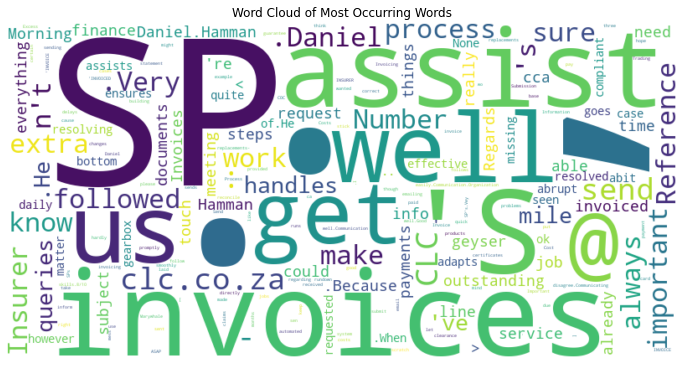

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
!pip install wordcloud 
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Set the NLTK data directory path
nltk.data.path.append("C:\\Users\\Ntsakisib\\nltk_data")

# Read the Excel file
df = pd.read_excel(r"C:\Users\Ntsakisib\OneDrive - Customer Loyalty Consultants\Documents - Procurement\KPI Documents\Daniel Data.xlsx")

# Extract text from the first column
text_column = df.iloc[:, 0]

# Combine all text into a single string
text = ' '.join(text_column)

# Tokenize the text
tokens = word_tokenize(text)

# Remove stop words
stop_words = set(stopwords.words('english'))
filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

# Create a frequency distribution of words
word_freq = nltk.FreqDist(filtered_tokens)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plotting
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Occurring Words')
plt.show()
